### Assignment 3

##### Deliar Mohammadi, 30072994
##### John Zheng,30125258
##### Xinzhou Li, 30066080



In [197]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch_optimizer as optim

import PIL
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import random
import os
import glob

### Building Train and Test Data classes

In [206]:
class Data():
    def __init__(self, root, csv_path, transform=None, ext='.jpg'): # move transform into training loop
        self.df_csv = pd.DataFrame(pd.read_csv((root+csv_path)))
        self.paths = self.df_csv['id']
        self.labels = self.df_csv['label']
        self.transform = transform
        self.root = root
        # print(self.all_file_paths)
        # print(self.all_labels)
        
    '''
    return length of the dataset
    '''
    def __len__(self):
        return len(self.paths)
    
    '''
    get the img,label tuple corresponding to index i
    '''
    def __getitem__(self, i):
        s = (self.root+'/'+self.paths.iat[i])
        img = Image.open(s)
        label = self.labels[i]
        if self.transform:
            img = self.transform(img)
        return img, label
     
    '''
    get the img,label tuple corresponding to index i
    '''
    def get_no_transform(self, i):
        s = (self.root+'/'+self.paths.iat[i])
        img = Image.open(s)
        label = self.labels[i]
        return img, label
    
    '''
    Selects random start point in the dataset and prints 28 images
    Inputs:
        color-> 1 to print color images, 0 for grayscale images
    '''
    def print_samples(self):
        figure, axes = plt.subplots(3, 7, figsize=(18,10))
        axes = axes.flatten()
        i = random.randint(0, len(self)-29)
        
        for axis in axes:
            x = self.get_no_transform(i)
            axis.imshow(x[0])
            label = x[1]
            axis.set_xlabel(label)
            i+=1
        plt.tight_layout()
        plt.show()
    
    '''
    Calculates average width and height of all images in dataset
    '''
    def calc_average_dimension(self):
        totalw = 0
        totalh = 0
        for i in range(len(self.paths)):
            image = (self.get_no_transform(i))[0]
            w, h = image.size
            totalw += w
            totalh += h
        avgw = totalw//len(self)
        avgh = totalh//len(self)
        return avgw, avgh

## Preparing Training & Validation datasets, dataloaders and transforms

In [207]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.4),
    transforms.ColorJitter(brightness=0.2),
    transforms.ColorJitter(contrast=0.5),
    transforms.ColorJitter(saturation=0.5),
    
    transforms.Resize(size=256),     
    torchvision.transforms.CenterCrop(224), #required for resnet50 input: 224x224
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalized with imagenet mean and std deviation
])

In [208]:
validation_transform = transforms.Compose([
    transforms.Resize(size=256),     
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [210]:
all_data = Data("./Assignment 3 Dataset", "/train.csv", train_transform)
print("Average Image Dimensions for all data:", all_data.calc_average_dimension())
print("Total number of examples:", len(all_data))

Average Image Dimensions for all data: (667, 461)
Total number of examples: 4135


In [211]:
train_dataset, validation_dataset = torch.utils.data.random_split(all_data,[4000,135])

#### Sampels of training and test data

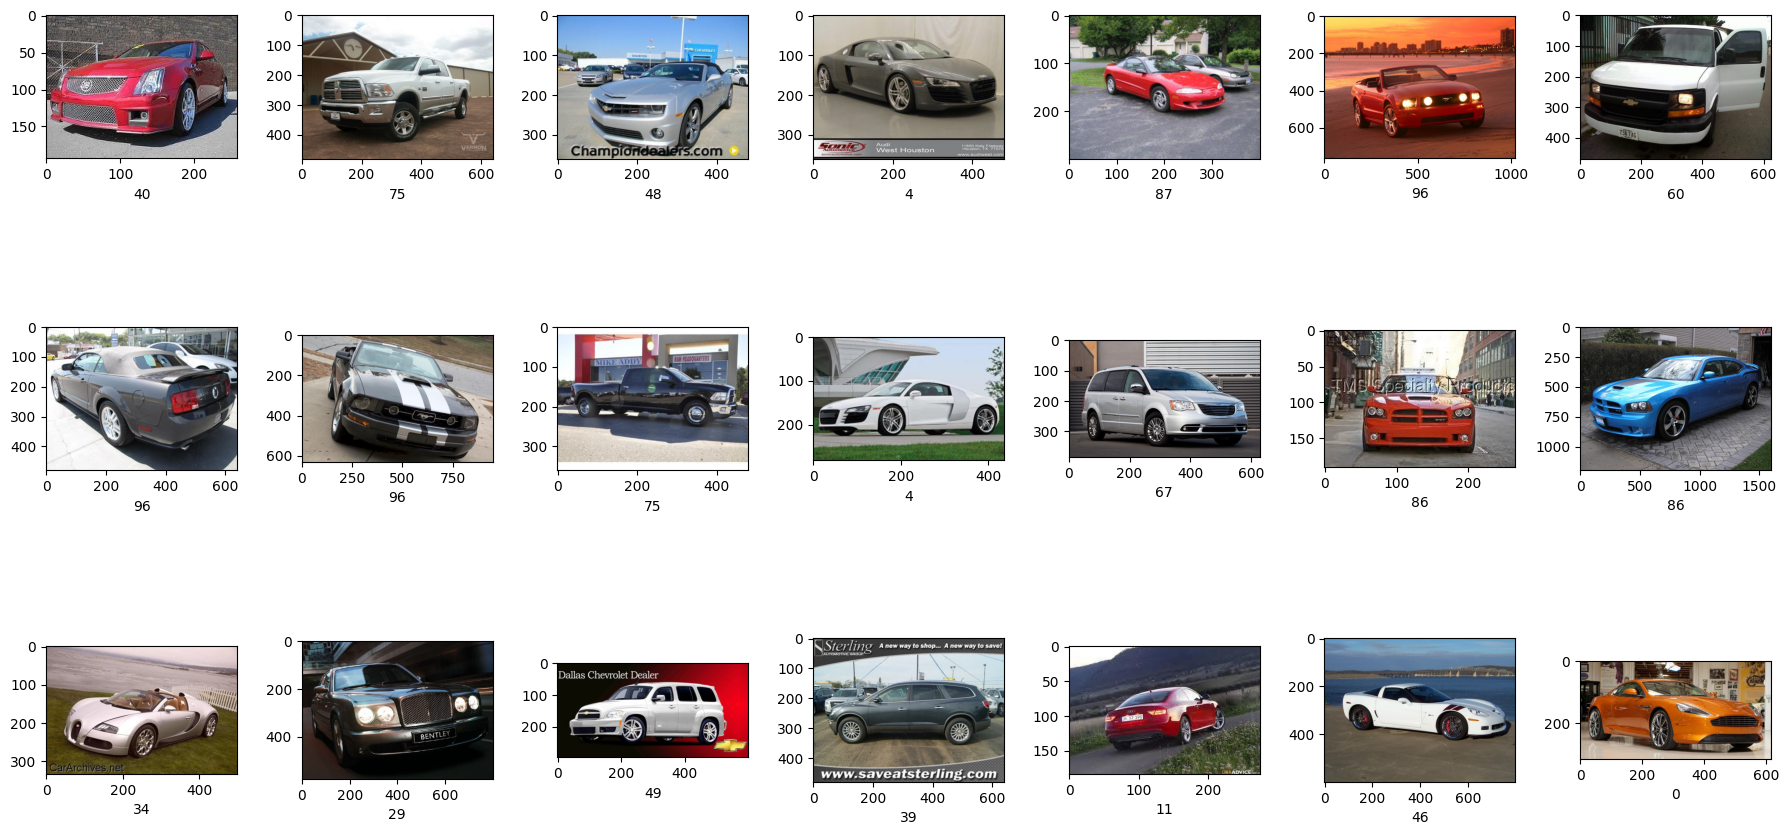

In [183]:
all_data.print_samples()

## Building the Model and Training

In [156]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
model = models.resnet50(weights=True).to(device)

for param in model.parameters():
    param.requires_grad = True # False to freeze the model

model.classifier = nn.Sequential(
           nn.Linear(2048, 128),
           nn.ReLU(inplace=True),
           nn.Linear(128, 100))

model.to(device)

In [158]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [ ]:
epochs = 10
model.train()
for i in range(epochs):
    
    epoch_loss = 0
    num_examples = 0
    correct_examples = 0
    
    for batch_index,(images,labels) in enumerate(train_dataloader):
        # reset optimizer for the current batch
        optimizer.zero_grad() 
        # load images and labels
        images = images.to(device)
        labels = labels.to(device)
        # calculate output and loss from output
        outputs = model(images)
        loss = loss_function(outputs,labels)
        # loss.backward() calculates all gradients for all params, optimizer.step() updates params using our optimizer
        loss.backward()
        optimizer.step()
        # calculate information for this epoch
        epoch_loss += loss.item()*len(labels)
        num_examples += len(labels)
        # calculate predictions and accuracy
        _,preds = torch.max(outputs,1) # calcualtae max in each column (second value=1 for column)
        correct_examples += (preds==labels).sum().item()
        
    # AFTER epoch we calculate accuracy
    train_accuracy = (correct_examples/num_examples)*100
    print(f'Epoch {i}: Training Accuracy: {train_accuracy:.4f}%, Training Loss: {epoch_loss:.4f}')

### Sources

https://pytorch.org/vision/stable/models.html

https://discuss.pytorch.org/t/what-does-it-mean-to-normalize-images-for-resnet/96160